# Object Identification 

This notebook showcases the different object identification methods in MontePython using observed radar data. 

We have create a dataset with 3 different inputs to be used with 
our object identifiers: 
   * VIL (Vertically Integrated Liquid) 
   * Composite_Reflectivity (Column-maximum reflectivity) 
   * Lowest Level Reflectivity

The reflectivity data was threholded for meteorological data with dr < -12 as per Kilambi (2018,  https://doi.org/10.1175/JTECH-D-17-0175.1)

We have conviently converted the azimuth/range data to xy coordinates on a 1 km grid
using inverse distance weighted (thanks wradlib!). This was accomplised with the [hotspot
repository](https://github.com/NOAA-National-Severe-Storms-Laboratory/hotspots).



In [1]:
import sys, os
package_path = os.path.dirname(os.getcwd())
sys.path.insert(0, package_path)
import monte_python
from monte_python.util import get_obj_cmap

import gzip
import shutil
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update(
        {'font.size': 14.0,
         'axes.titlesize': 'x-large',
         'axes.linewidth': 2.0,
         'axes.labelsize': 'large'}
    )


# Util for loading the netcdf file as an Xarray dataset.

def load_as_xarray_ds(path):
    # Make absolute path
    path = os.path.abspath(path)
    
    # Step 1: Decompress if needed
    if path.lower().endswith('.gz'):
        decompressed_path = os.path.join(os.path.dirname(path), "data.nc")
        with gzip.open(path, "rb") as f_in:
            with open(decompressed_path, "wb") as f_out:
                shutil.copyfileobj(f_in, f_out)
        path = decompressed_path
    
    print(f'Loading {path=}')
    return xr.load_dataset(path)

# Check if 'NWSRef' colormap exists, otherwise fall back to 'rainbow'
cmap = 'NWSRef' if 'NWSRef' in plt.colormaps() else 'rainbow'

### Load the provided netCDF files. 

The included files are: 
* KCYS_2017-06-12T20:29:10Z.nc.gz : Isolated Cell Data 
* KOAX_2014-06-03T21:36:49Z.nc.gz : Multi-Celluar Data

In [2]:
path = "ncfiles/KOAX_2014-06-03T21:36:49Z.nc.gz"
ds_xy = load_as_xarray_ds(path)
ds_xy

Loading path='/home/john.krause/python/test/frdd-monte-python/tutorial_notebooks/ncfiles/data.nc'


<xarray.Dataset>
Dimensions:     (x: 601, y: 601)
Coordinates:
  * x           (x) int64 -300 -299 -298 -297 -296 -295 ... 296 297 298 299 300
  * y           (y) int64 -300 -299 -298 -297 -296 -295 ... 296 297 298 299 300
    lon         (x) float64 -99.82 -99.81 -99.79 -99.78 ... -92.64 -92.63 -92.62
    lat         (y) float64 38.57 38.58 38.59 38.6 ... 43.93 43.94 43.95 43.96
Data variables:
    VIL         (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Comp_Ref    (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Lowest_Ref  (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    radar_name:            KOAX
    radar_latitude:        41.320369720458984
    radar_longitude:       -96.3668212890625
    radar_altitude:        384.0
    vcp_pattern:           212
    missing_value:         -9999.0
    vol_start_time:        2014-06-03T21:36:49Z
    coordinate_transfrom:  wradlib.ipol.Idw inverse distance weight

## Plot the raw data 

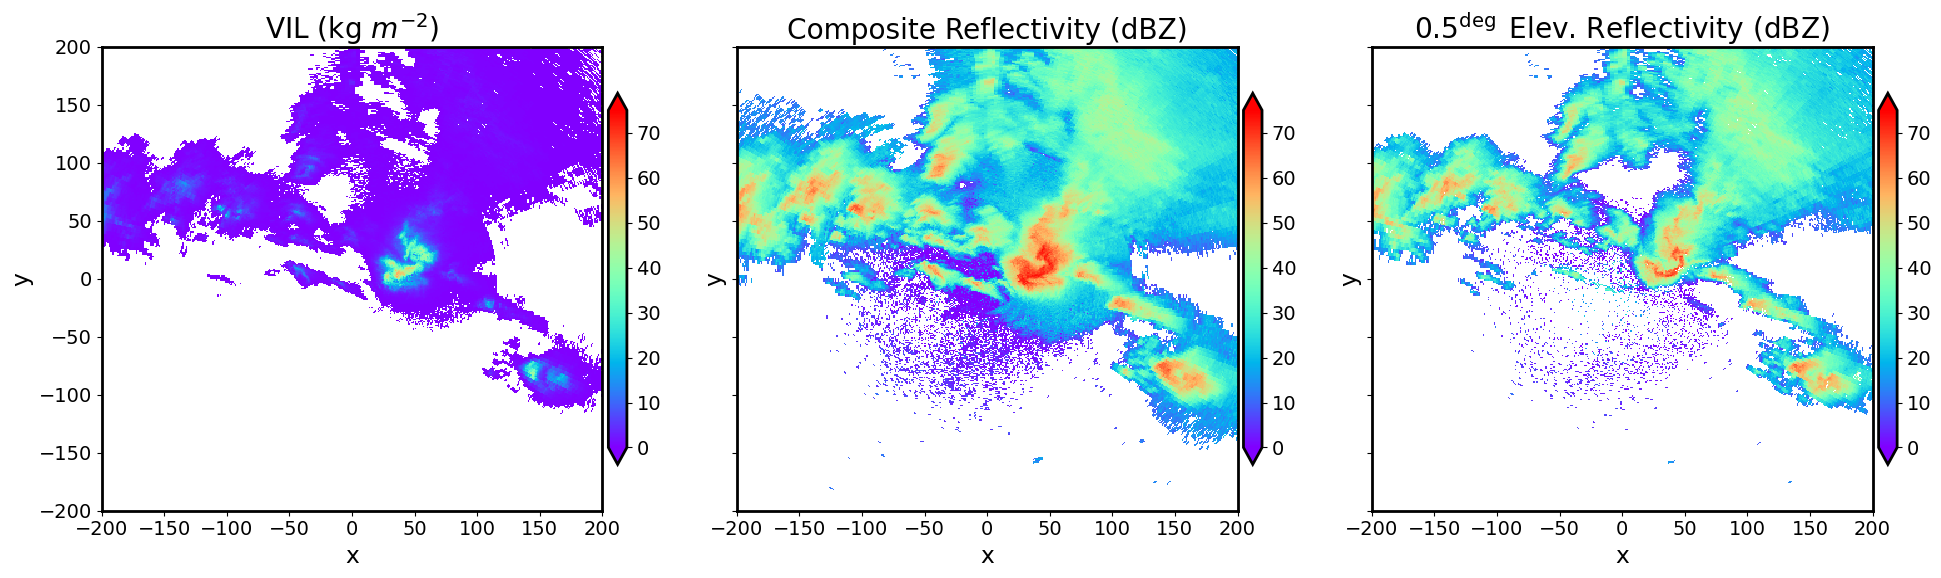

In [3]:
%matplotlib inline
vars_to_plot = ['VIL', 'Comp_Ref', 'Lowest_Ref']
titles = {'VIL': r'VIL (kg $m^{-2}$)',
          'Comp_Ref' : 'Composite Reflectivity (dBZ)',
          'Lowest_Ref' : r'0.5$^{\deg}$ Elev. Reflectivity (dBZ)'
         }

xlim = (-200, 200)
ylim = (-200, 200)

fig, axes = plt.subplots(figsize=(20, 6), ncols=len(vars_to_plot), sharey=True)

for ax, var in zip(axes.flat, vars_to_plot):
    ds_xy[var].where(ds_xy[var]>-10).plot(ax=ax, x='x', y='y', vmin=0.0, vmax=75.0,
                        xlim=xlim, ylim=ylim, cmap=cmap,
                        add_colorbar=True,
                        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'',
                                     'shrink':0.8})
    ax.set_title(titles[var])
    
plt.tight_layout() 
plt.show()

# Identifying Objects from VIL (Vertically Integrated Liquid) 

## Enhanced Watershed Method

The enhanced watershed method identifies local maxima and then grows objects pixel by pixel from a quantized version of the original field until they reach a specified area or intensity criteria (Lakshmanan et al. 2009). Objects are restricted from growing into regions less than the given minimum threshold (e.g., reflectivity > 40 dBZ) and once an object is identified, a larger region surrounding the objects is demarcated as a no-grow region for additional objects ensuring separation (i.e., the foothills region in Lakshmanan et al. 2009). Thus, the enhanced watershed algorithm is most powerful for identifying separate objects from clusters. However, the watershed algorithm does requires careful tuning to outperform the single threshold method. The different sensitivities and limitations of the watershed algorithm are provided in section 2c1 of Flora et al. (2019). In summary, the crucial parameters for the watershed algorithm are the minimum (``min_thresh``) and area (``area_threshold``) thresholds and the minimal distance between objects centers (``dist_btw_objects``). 

In [4]:
#parameter sets for the Enhanced Watershed Technique
EW_refl_params = {'min_thresh':25,
            'max_thresh':80,
            'data_increment':20,
            'area_threshold': 100,
            'dist_btw_objects': 25} 

EW_vil_params= {'min_thresh':5,
            'max_thresh':80,
            'data_increment':5,
            'area_threshold': 100,
            'dist_btw_objects': 25} 


data = ds_xy["VIL"].values
input_data = np.where(data > 1, data, 0)
storm_labels, object_props = monte_python.label(  input_data = input_data, 
                       method ='watershed', 
                       return_object_properties=True, 
                       params = EW_vil_params 
                       )

ds_xy["EW_vil_objects"] = (("y", "x"), storm_labels.data)

## Iterative Watershed Method 

The iterative watershed method was first introduced in Flora et al. (2021). As noted above, one limitation of the enhanced watershed algorithm is sensitivity to scale. To improve upon that watershed algorithm, we can apply multiple iterations of the watershed algorithm. The early iterations identify the larger-scale objects while later iterations attempt to identify smaller scale objects embedded within the larger scale objects. Another component of the iterative watershed algorithm is to associate all non-zero points with some object. This process ensures that the object areas are "true" to the original data.  With this improved method, the enhanced watershed may grow objects to a greater size while maintaining object separation

In [5]:
#Parameter Sets for the Iterative Watershed technique
param_set = [ {'min_thresh':35,
                                 'max_thresh':80,
                                 'data_increment':5,
                                 'area_threshold': 100,
                                 'dist_btw_objects': 50} , 
            
              {'min_thresh':45,
                                 'max_thresh':80,
                                 'data_increment':5,
                                 'area_threshold': 50,
                                 'dist_btw_objects': 10} 
            ]

IW_refl_params = {'params': param_set }

param_set = [ {'min_thresh':5,
                                 'max_thresh':60,
                                 'data_increment':2,
                                 'area_threshold': 100,
                                 'dist_btw_objects': 50} , 
            
              {'min_thresh':30,
                                 'max_thresh':60,
                                 'data_increment':2,
                                 'area_threshold': 50,
                                 'dist_btw_objects': 10} 
            ]

IW_vil_params = {'params': param_set }
data = ds_xy["VIL"].values
input_data = np.where(data > 2, data, 0)
storm_labels, object_props = monte_python.label(  input_data = input_data, 
                       method ='iterative_watershed', 
                       return_object_properties=True, 
                       params = IW_vil_params 
                       )
ds_xy["IW_vil_objects"] = (("y", "x"), storm_labels.data)

## MCIT Method

The multi-cell identification and tracking (MCIT) method was first propsed in D. Rosenfeld (1987, https://doi.org/10.1175/1520-0426(1987)004<0422:OMFAAT>2.0.CO;2) and updated in Jiaxi Hu, et al. (2019, https://doi.org/10.1016/j.atmosres.2019.04.015). 

MCIT is watershed based, but overcomes oversegmentation of the data common to watershed techniques by combing watersheds whose maximum values are not seperated by a deep enough valley (valley depth) along the interface between the two watersheds. Also the minimum value parameter can help limit the area extent of the objects to manageable size, but if like the iterative watershed technique, you want a object label for each non-zero point it can be safely ignored at the cost of increased computational time. 

Hu (2019) notes: "the MCIT algorithm works better in relative strength, the algorithm uses 10log10(VIL) in units of dB" while this observation (10*log10(data) works better than data) may be applicable to all watershed techniques (enhanced, iterative, MCIT), for simplicity it is not reflected in the examples below. We also recommed smoothing the data with a 3x3 median box filter before the application the watershed technique, if computational time allows.  


In [6]:
#Parameter sets for MCIT
MCIT_refl_params = {'params': {'valley_depth': 5.0, 'min_value': 30.0 } }
MCIT_vil_params = {'params': {'valley_depth': 2.0, 'min_value': 1.0 } }
data = ds_xy["VIL"].values
input_data = np.where(data > 2, data, 0)
storm_labels, object_props = monte_python.label(  input_data = input_data, 
                       method ='mcit', 
                       return_object_properties=True, 
                       params = MCIT_vil_params 
                       )
ds_xy["MCIT_vil_objects"] = (("y", "x"), storm_labels.data)

mcit params: 


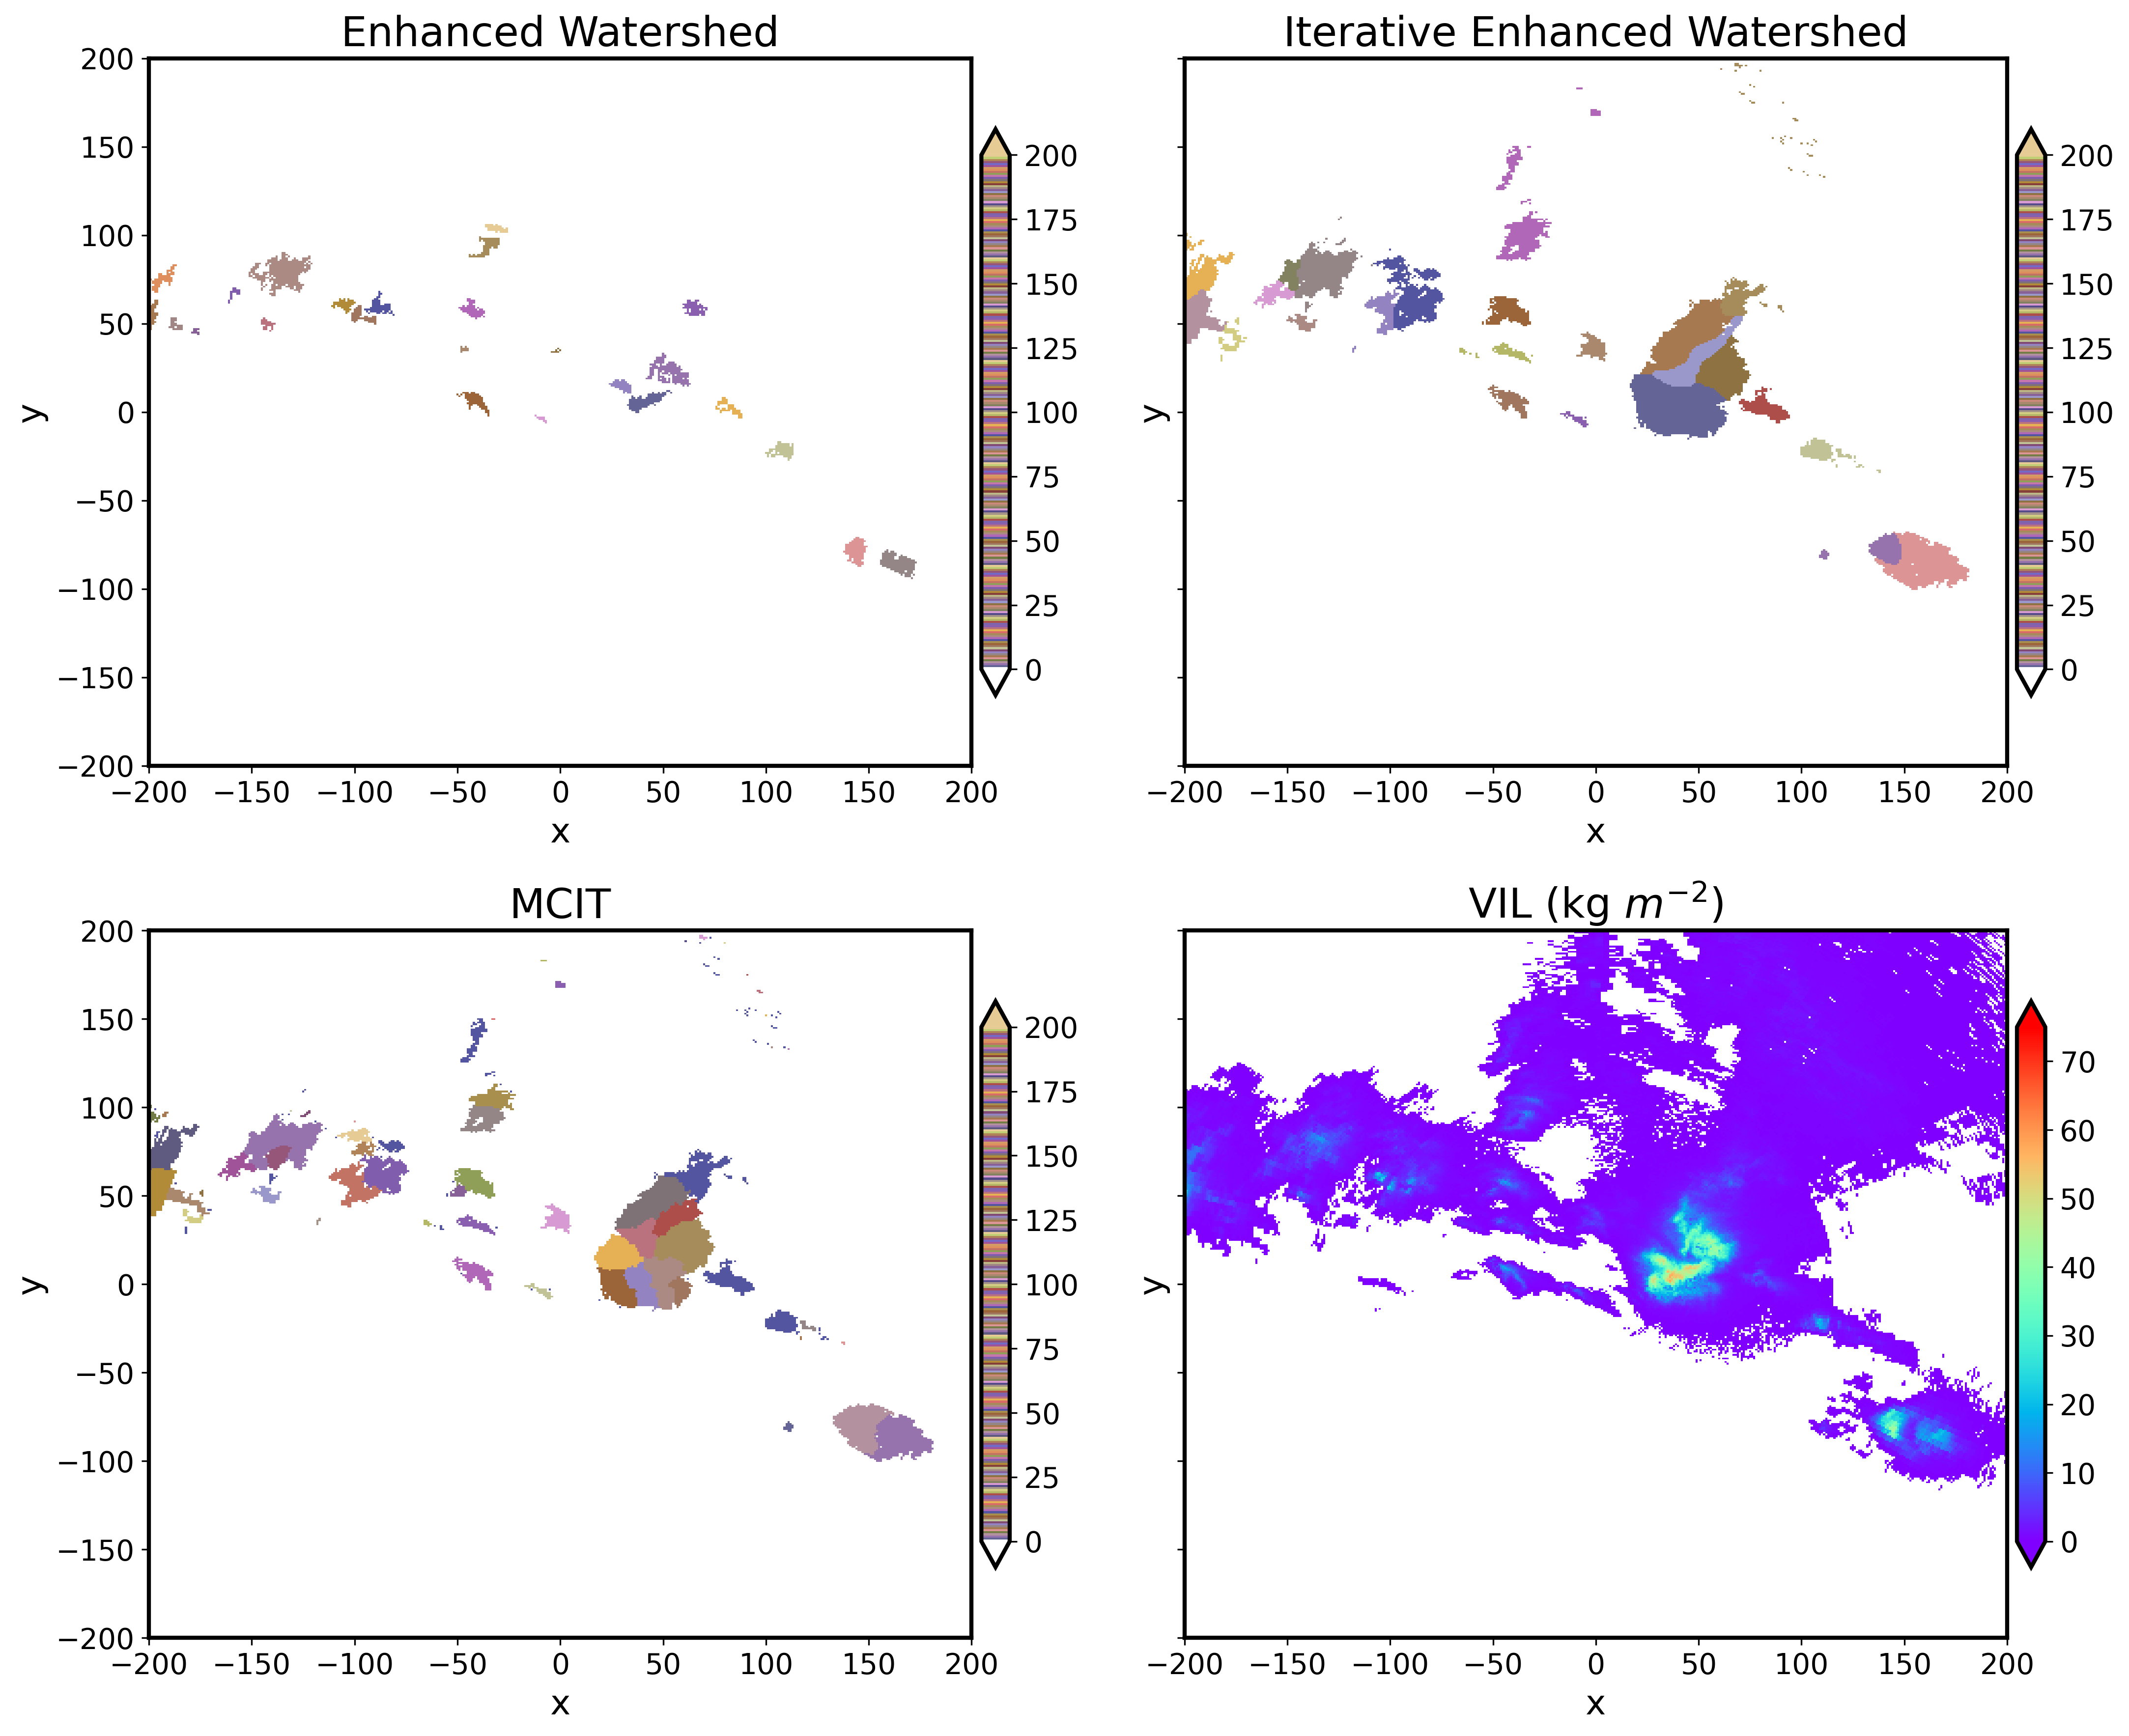

In [7]:
%matplotlib inline

object_vars = ["EW_vil_objects", "IW_vil_objects", "MCIT_vil_objects"]
raw_vars = ['VIL', 'Comp_Ref', 'Lowest_Ref']

titles = {"EW_vil_objects": 'Enhanced Watershed',
          "IW_vil_objects" : 'Iterative Enhanced Watershed',
          "MCIT_vil_objects" : 'MCIT',
          'VIL': r'VIL (kg $m^{-2}$)',
          'Comp_Ref' : 'Composite Reflectivity (dBZ)',
          'Lowest_Ref' : r'0.5$^{\deg}$ Elev. Reflectivity (dBZ)'
         }

xlim = (-200, 200)
ylim = (-200, 200)

fig, axes = plt.subplots(figsize=(15, 12),
                         ncols=2, 
                         dpi=300,
                         nrows=2,
                         sharey=True)

for ax, var in zip(axes[:,:].flat, object_vars):
    ds_xy[var].where(ds_xy[var]>-10).plot(ax=ax, x='x', y='y', vmin=0.0, vmax=200.0,
                        xlim=xlim, ylim=ylim, cmap=get_obj_cmap(),
                        add_colorbar=True,
                        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'',
                                     'shrink':0.8})
    ax.set_title(titles[var])
    
# Plot the raw data in the last spot.
var = 'VIL'
ds_xy[var].where(ds_xy[var]>-10).plot(ax=axes[-1,-1], x='x', y='y', vmin=0.0, vmax=75.0,
                        xlim=xlim, ylim=ylim, cmap=cmap,
                        add_colorbar=True,
                        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'',
                                     'shrink':0.8})
axes[-1,-1].set_title(titles[var])
plt.tight_layout()
plt.show()    

# Identifying Objects from Composite Reflectivity and lowest level Reflectivity

In [8]:
#compute the objet identifiers on the composite refl and lowest refl
data = ds_xy["Comp_Ref"].values

#print(type(data))
#print(data.shape)
input_data = np.where(data > 1, data, 0)
#data_tuple = (dim_tuple, input_data)
storm_labels, object_props = monte_python.label(  input_data = input_data, 
                       method ='watershed', 
                       return_object_properties=True, 
                       params = EW_refl_params 
                       )
ds_xy["EW_cr_objects"] = (("y", "x"), storm_labels.data)

In [9]:
data = ds_xy["Comp_Ref"].values

input_data = np.where(data > 2, data, 0)
storm_labels, object_props = monte_python.label(  input_data = input_data, 
                       method ='iterative_watershed', 
                       return_object_properties=True, 
                       params = IW_refl_params 
                       )
ds_xy["IW_cr_objects"] = (("y", "x"), storm_labels.data)

In [10]:
data = ds_xy["Comp_Ref"].values
input_data = np.where(data > 2, data, 0)
storm_labels, object_props = monte_python.label(  input_data = input_data, 
                       method ='mcit', 
                       return_object_properties=True, 
                       params = MCIT_refl_params 
                       )
ds_xy["MCIT_cr_objects"] = (("y", "x"), storm_labels.data)

mcit params: 


In [11]:
data = ds_xy["Lowest_Ref"].values

input_data = np.where(data > 1, data, 0)
#data_tuple = (dim_tuple, input_data)
storm_labels, object_props = monte_python.label(  input_data = input_data, 
                       method ='watershed', 
                       return_object_properties=True, 
                       params = EW_refl_params 
                       )
ds_xy["EW_lr_objects"] = (("y", "x"), storm_labels.data)

In [12]:
data = ds_xy["Lowest_Ref"].values

input_data = np.where(data > 2, data, 0)
storm_labels, object_props = monte_python.label(  input_data = input_data, 
                       method ='iterative_watershed', 
                       return_object_properties=True, 
                       params = IW_refl_params 
                       )
ds_xy["IW_lr_objects"] = (("y", "x"), storm_labels.data)

In [13]:
data = ds_xy["Lowest_Ref"].values
input_data = np.where(data > 2, data, 0)
storm_labels, object_props = monte_python.label(  input_data = input_data, 
                       method ='mcit', 
                       return_object_properties=True, 
                       params = MCIT_refl_params 
                       )
ds_xy["MCIT_lr_objects"] = (("y", "x"), storm_labels.data)

mcit params: 


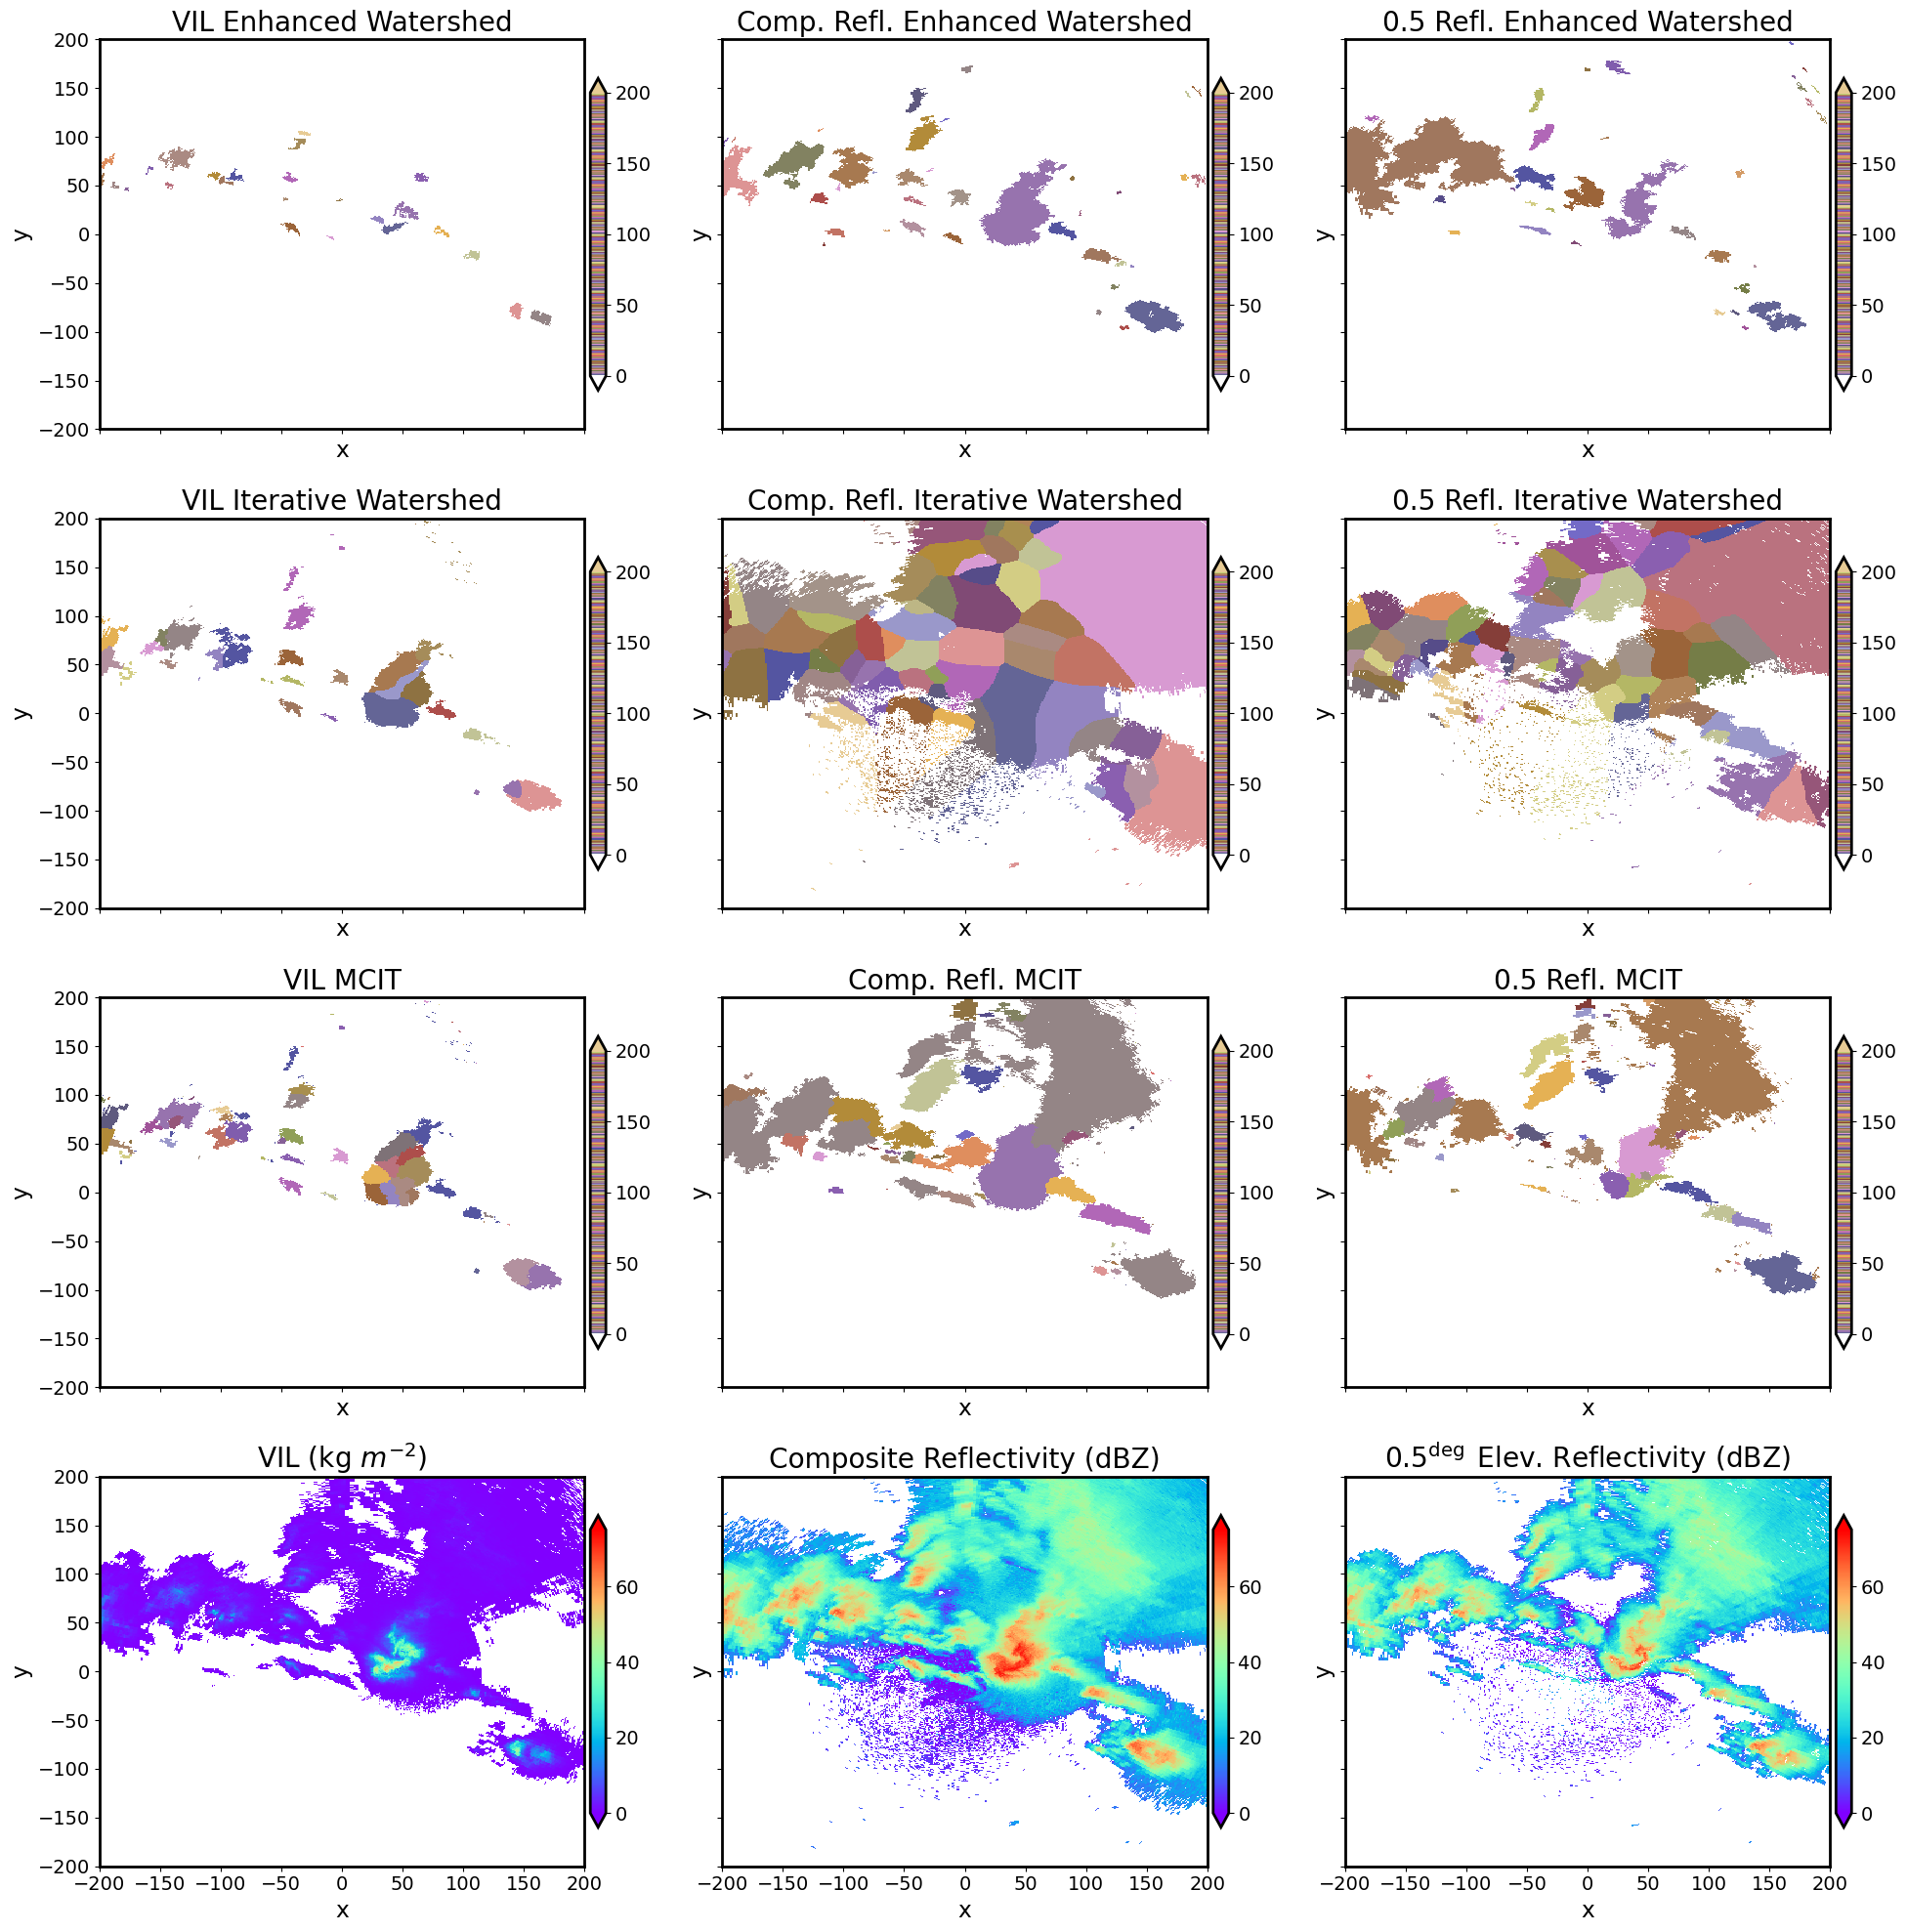

In [15]:
import itertools 

methods = ["EW", "IW", "MCIT"]
variables = ["vil", "cr", "lr"]

object_vars = [f"{m}_{v}_objects" for m,v in itertools.product(methods, variables)]

methods_dict = {
    'EW' : 'Enhanced Watershed', 
    'IW' : 'Iterative Watershed',
    'MCIT' : 'MCIT'
}

variables_dict = {
    'vil' : 'VIL',
    'cr' : 'Comp. Refl.',
    'lr' : '0.5 Refl.'
}


xlim = (-200, 200)
ylim = (-200, 200)

fig, axes = plt.subplots(figsize=(20, 20),
                         ncols=3, 
                         nrows=4,
                         sharey=True, 
                        sharex=True)


for ax, var in zip(axes[:,:].flat, object_vars):
    ds_xy[var].where(ds_xy[var]>-10).plot(ax=ax, x='x', y='y', vmin=0.0, vmax=200.0,
                        xlim=xlim, ylim=ylim, cmap=get_obj_cmap(),
                        add_colorbar=True,
                        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'',
                                     'shrink':0.8})
    
    m, v, _ = var.split('_')
    title = f'{variables_dict[v]} {methods_dict[m]}'
    ax.set_title(title)

for ax, var in zip(axes[-1, :], raw_vars):

    ds_xy[var].where(ds_xy[var]>-10).plot(ax=ax, x='x', y='y', vmin=0.0, vmax=75.0,
                        xlim=xlim, ylim=ylim, cmap=cmap,
                        add_colorbar=True,
                        cbar_kwargs={'extend':'both', 'pad':0.01, 'label':'',
                                     'shrink':0.8})
    ax.set_title(titles[var])
    
plt.tight_layout()
plt.show()    
